In [1]:
!pip install -r requirements.txt

In [2]:
# Installing the necessary libraries

import pmdarima as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sktime.forecasting.arima import ARIMA as sktime_ARIMA
from sktime.forecasting.model_selection import temporal_train_test_split


In [9]:
# Alternative method to load the AirPassengers dataset using pandas
import pandas as pd

# URL for the AirPassengers dataset (CSV format)
data_url = 'https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv'

# Load the dataset into a pandas DataFrame
data = pd.read_csv(data_url)

# Convert the 'Month' column to datetime objects and set it as the index
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')['#Passengers']

# Display the first few rows of the loaded data
display(data.head())

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [11]:
# Split the data into training and testing sets manually using pandas slicing
# 80% of the data will be used for training and 20% for testing.
split_index = int(len(data) * 0.8)
train = data[:split_index]
test = data[split_index:]

# Define the forecasting horizon for sktime based on the test set index
fh_test = test.index

print("Data loaded and split into training and testing sets.")

Data loaded and split into training and testing sets.


In [12]:
# --- 2. Model Fitting and Forecasting ---

# Model 1: pmdarima (Automatic Model Selection)
print("\n--- Fitting pmdarima SARIMA model ---")
model_pm = pm.auto_arima(train, seasonal=True, m=12,
                         d=1, D=1, start_p=0, start_q=0,
                         max_p=3, max_q=3, max_P=2, max_Q=2,
                         trace=False,  # Set to True for verbose output
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
forecasts_pm = model_pm.predict(n_periods=len(test))


--- Fitting pmdarima SARIMA model ---


In [13]:
# Model 2: statsmodels (Manual Parameter Selection)
print("\n--- Fitting statsmodels SARIMAX model ---")
# Manually defining parameters (p, d, q) for non-seasonal and (P, D, Q, m) for seasonal part
order = (2, 1, 1)
seasonal_order = (0, 1, 0, 12)
model_sm = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                   enforce_stationarity=False, enforce_invertibility=False)
results_sm = model_sm.fit(disp=False)
forecasts_sm = results_sm.predict(start=len(train), end=len(train) + len(test) - 1)



--- Fitting statsmodels SARIMAX model ---


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [18]:
# # Model 3: sktime (Unified API)
# print("\n--- Fitting sktime ARIMA model ---")
# # sktime's ARIMA is a convenient wrapper around pmdarima's auto_arima
# forecaster_sk = sktime_ARIMA(suppress_warnings=True)
# forecaster_sk.fit(train)
# forecasts_sk = forecaster_sk.predict(fh_test)



--- Performance Comparison ---
Library      MAE        MSE        RMSE      
---------------------------------------------
pmdarima     28.55      1230.80    35.08     
statsmodels  27.13      1131.98    33.64     


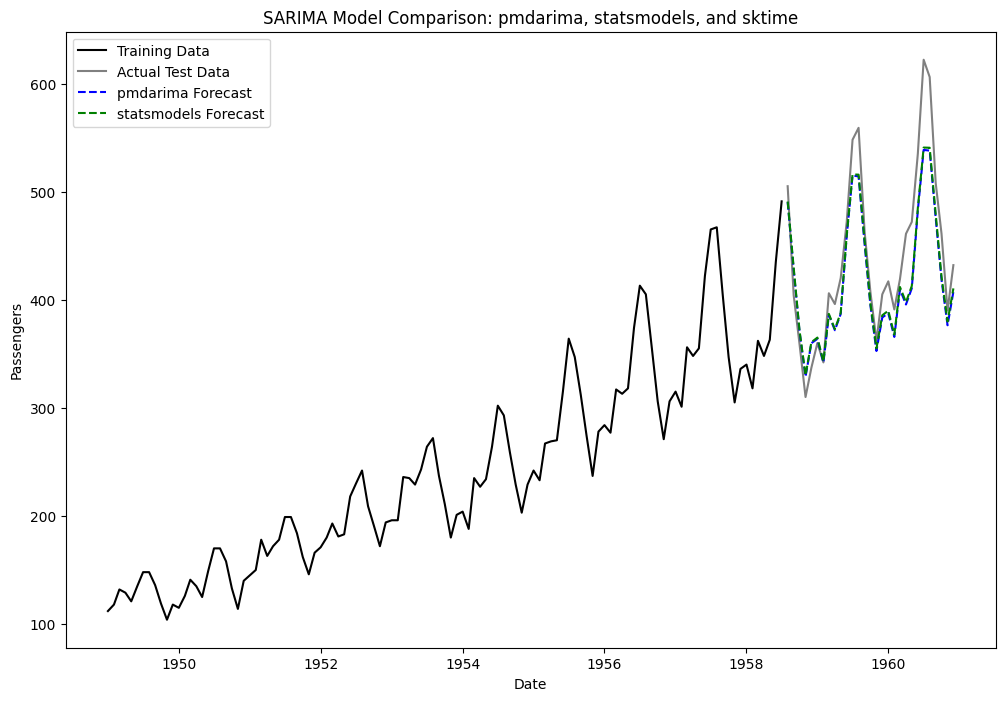

In [19]:
# --- 3. Performance Metrics Calculation and Comparison ---

def calculate_metrics(y_true, y_pred):
    """Calculates MAE, MSE, and RMSE."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Calculate metrics for each model
mae_pm, mse_pm, rmse_pm = calculate_metrics(test, forecasts_pm)
mae_sm, mse_sm, rmse_sm = calculate_metrics(test, forecasts_sm)
# mae_sk, mse_sk, rmse_sk = calculate_metrics(test, forecasts_sk)

print("\n--- Performance Comparison ---")
print("{:<12} {:<10} {:<10} {:<10}".format("Library", "MAE", "MSE", "RMSE"))
print("-" * 45)
print("{:<12} {:<10.2f} {:<10.2f} {:<10.2f}".format("pmdarima", mae_pm, mse_pm, rmse_pm))
print("{:<12} {:<10.2f} {:<10.2f} {:<10.2f}".format("statsmodels", mae_sm, mse_sm, rmse_sm))
# print("{:<12} {:<10.2f} {:<10.2f} {:<10.2f}".format("sktime", mae_sk, mse_sk, rmse_sk))

# --- 4. Plotting the Comparison ---

plt.figure(figsize=(12, 8))
plt.plot(train, label='Training Data', color='black')
plt.plot(test, label='Actual Test Data', color='grey')
plt.plot(test.index, forecasts_pm, label='pmdarima Forecast', color='blue', linestyle='--')
plt.plot(test.index, forecasts_sm, label='statsmodels Forecast', color='green', linestyle='--')
# plt.plot(test.index, forecasts_sk, label='sktime Forecast', color='red', linestyle='--')
plt.title('SARIMA Model Comparison: pmdarima, statsmodels, and sktime')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

| Feature          | pmdarima (`auto_arima`)                     | statsmodels (`SARIMAX`)                       |
|------------------|---------------------------------------------|-----------------------------------------------|
| **Approach**     | Automatic Model Selection                   | Manual Parameter Specification                |
| **Ease of Use**  | Generally easier for quick modeling       | Requires more manual effort and expertise     |
| **Flexibility**  | Less flexible in manual parameter tuning    | More flexible and granular control over model |
| **Output/Diagnostics** | Provides model summary and basic info     | Offers comprehensive statistical tests and diagnostics |
| **Primary Use Case** | Quickly finding a suitable model        | In-depth analysis and custom model building |

                                      SARIMAX Results                                      
Dep. Variable:                         #Passengers   No. Observations:                  115
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -368.442
Date:                             Mon, 15 Sep 2025   AIC                            744.884
Time:                                     08:09:49   BIC                            755.305
Sample:                                 01-01-1949   HQIC                           749.102
                                      - 07-01-1958                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5733      0.733     -0.782      0.434      -2.011       0.864
ar.L2          0.0326      

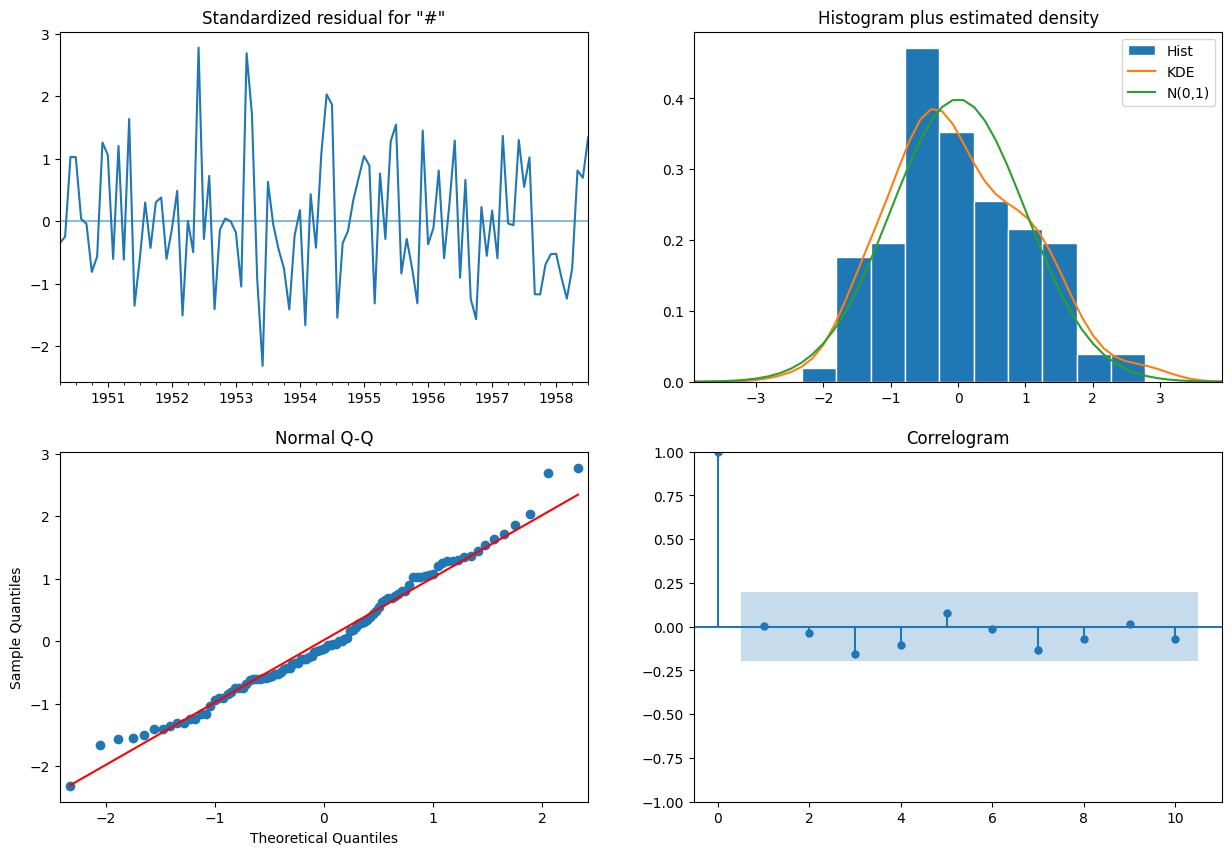

In [20]:
# Demonstrate comprehensive tests and diagnostics from statsmodels

# Print the model summary
print(results_sm.summary())

# Plot diagnostics
results_sm.plot_diagnostics(figsize=(15, 10))
plt.show()

Optimal non-seasonal order (p, d, q): (1, 1, 0)
Optimal seasonal order (P, D, Q, m): (0, 1, 0, 12)

--- Fitting statsmodels SARIMAX model with pmdarima's optimal parameters ---

--- Performance with statsmodels using pmdarima's optimal parameters ---
Library      MAE        MSE        RMSE      
---------------------------------------------
statsmodels (optimal) 28.57      1232.22    35.10     


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


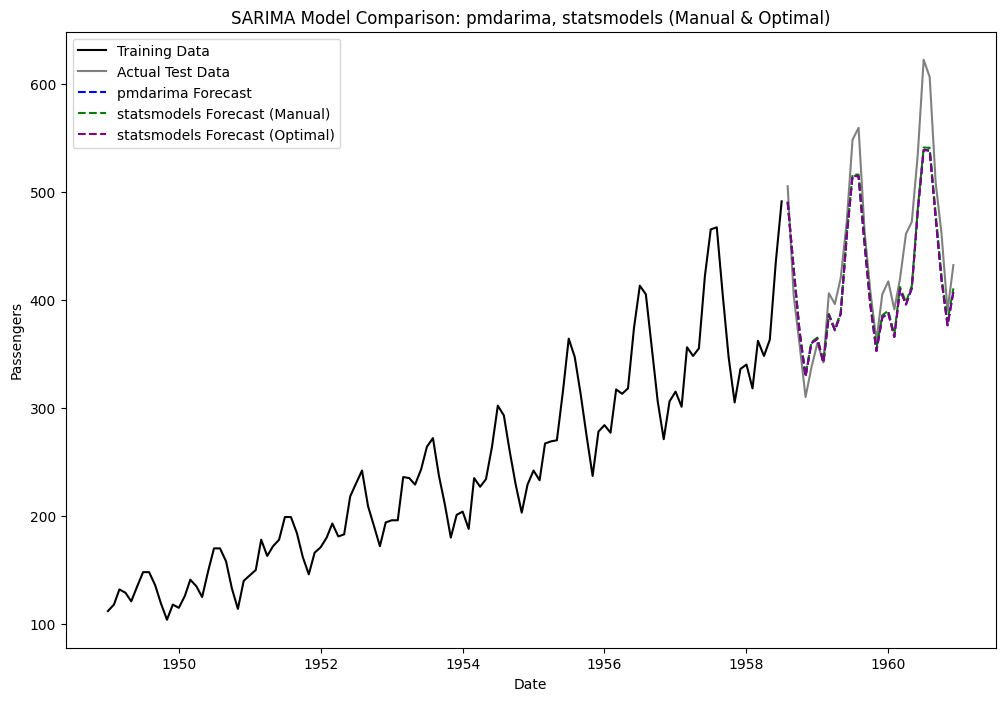

In [21]:
# Use parameters found by pmdarima's auto_arima in statsmodels SARIMAX

# Get the optimal order and seasonal order from the fitted pmdarima model
optimal_order = model_pm.order
optimal_seasonal_order = model_pm.seasonal_order

print(f"Optimal non-seasonal order (p, d, q): {optimal_order}")
print(f"Optimal seasonal order (P, D, Q, m): {optimal_seasonal_order}")

# Fit a statsmodels SARIMAX model using the optimal parameters
print("\n--- Fitting statsmodels SARIMAX model with pmdarima's optimal parameters ---")
model_sm_optimal = SARIMAX(train, order=optimal_order, seasonal_order=optimal_seasonal_order,
                           enforce_stationarity=False, enforce_invertibility=False)
results_sm_optimal = model_sm_optimal.fit(disp=False)

# Generate forecasts using the new statsmodels model
forecasts_sm_optimal = results_sm_optimal.predict(start=len(train), end=len(train) + len(test) - 1)

# Calculate and print metrics for the new model
mae_sm_optimal, mse_sm_optimal, rmse_sm_optimal = calculate_metrics(test, forecasts_sm_optimal)

print("\n--- Performance with statsmodels using pmdarima's optimal parameters ---")
print("{:<12} {:<10} {:<10} {:<10}".format("Library", "MAE", "MSE", "RMSE"))
print("-" * 45)
print("{:<12} {:<10.2f} {:<10.2f} {:<10.2f}".format("statsmodels (optimal)", mae_sm_optimal, mse_sm_optimal, rmse_sm_optimal))

# Plot the forecast from the new statsmodels model alongside the others
plt.figure(figsize=(12, 8))
plt.plot(train, label='Training Data', color='black')
plt.plot(test, label='Actual Test Data', color='grey')
plt.plot(test.index, forecasts_pm, label='pmdarima Forecast', color='blue', linestyle='--')
plt.plot(test.index, forecasts_sm, label='statsmodels Forecast (Manual)', color='green', linestyle='--')
plt.plot(test.index, forecasts_sm_optimal, label='statsmodels Forecast (Optimal)', color='purple', linestyle='--')
plt.title('SARIMA Model Comparison: pmdarima, statsmodels (Manual & Optimal)')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()